# TISSUE filtering improvements on simulated spatial transcriptomics data

This notebook contains code for generating simulations and showing improvements in TISSUE filtering over unfiltered predicted gene expression inputs for various downstream tasks including supervised learning (classification), clustering, and visualization.

It relies on simulated data files generated by `00_generate_srtsim_data.R` followed by `00_format_srtsim_data.ipynb`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
import squidpy as sq
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import umap
import anndata as ad
import warnings
import time
import pickle
import os

from decimal import Decimal

from TISSUE.tissue.main import *
from TISSUE.tissue.downstream import *

from sklearn.metrics import adjusted_rand_score
from scipy.stats import ttest_rel
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Function for simulating prediction mix-in bias from SRTsim-generated synthetic spatial transcriptomics

In [2]:
def simulate_data_fromfile (dataset_name, sigma_imputation=0.1, mixing=0.2, prop_biased=0.9, random_state=None, mixin_setup=["A","B"]):
    '''
    Creates data for simulation of imputation bias between conditions
    
    "condition" must be a column in the Metadata.txt file and contain "A" and "B" only
    '''
    # read in dataset
    adata = load_spatial_data("DataUpload/"+dataset_name+"/Spatial_count.txt",
                              "DataUpload/"+dataset_name+"/Locations.txt",
                              "DataUpload/"+dataset_name+"/Metadata.txt")
    
    # subset to overexpression fold changes
    adata = adata[:,[x for x in adata.var_names if int(x.split("noise")[-1].split("signal")[-1])<=round(adata.shape[1]/3)]]
    
    # prediction simulation with added bias
    measured = np.array(adata.X.copy())
    imputed = np.empty_like(measured)
    A_idxs = list(np.where(adata.obs["condition"] == mixin_setup[0])[0])
    B_idxs = list(np.where(adata.obs["condition"] == mixin_setup[1])[0])
    if random_state is not None:
        np.random.seed(random_state)
    bias_idxs = list(np.random.choice(np.arange(adata.shape[1]), size=round(adata.shape[1]*prop_biased), replace=False))
    nobias_idxs = [i for i in range(adata.shape[1]) if i not in bias_idxs]
    
    # impute one half consistently with zero-centered Gaussian noise
    if random_state is not None:
        np.random.seed(random_state)
    imputed[:,nobias_idxs] = measured[:,nobias_idxs] + np.random.normal(0,sigma_imputation,(imputed.shape[0],len(nobias_idxs)))
    
    # impute other half with bias of mu offset for one group
    n_mix = round(mixing*len(B_idxs))
    if random_state is not None:
        np.random.seed(random_state)
    random_idxs = np.random.choice(B_idxs,n_mix,replace=False)
    other_idxs = [i for i in range(adata.shape[0]) if i not in random_idxs]
    
    # construct bias offset based on sampling from group A
    mix_in_noise_mat = np.zeros((n_mix,len(bias_idxs)))
    for mxi, bi in enumerate(bias_idxs):
        gene = adata.var_names[bi]
        if random_state is not None:
            np.random.seed(random_state)
        mixin_draws = np.random.choice(adata[adata.obs.condition==mixin_setup[0],gene].X.flatten(), n_mix, replace=True)
        if random_state is not None:
            np.random.seed(random_state)
        mix_in_noise_mat[:,mxi] = (mixin_draws-adata[:,gene].X[random_idxs].flatten()) + np.random.normal(0,sigma_imputation,n_mix)
    
    imputed[np.ix_(random_idxs,bias_idxs)] = measured[np.ix_(random_idxs,bias_idxs)] + mix_in_noise_mat
    if random_state is not None:
        np.random.seed(random_state)
    imputed[np.ix_(other_idxs,bias_idxs)] = measured[np.ix_(other_idxs,bias_idxs)] + np.random.normal(0,sigma_imputation,
                                                      (adata.shape[0]-n_mix,len(bias_idxs)))
    
    # create adata
    adata.obsm["sim_predicted_expression"] = pd.DataFrame(imputed, columns=adata.var_names, index=adata.obs_names)
    
    # get calib genes (50%)
    calib_genes=np.random.choice(adata.var_names,round(adata.shape[1]/2),replace=False)
    
    labels = np.array([0 if x==mixin_setup[0] else 1 for x in adata.obs["condition"]])
    
    return (adata, calib_genes, labels)

## Figures for overview of simulation data

In [5]:
# generate simulation
adata, calib_genes, labels = simulate_data_fromfile("SRTsim_main_two_conditions_different", mixing=0.9, prop_biased=1, random_state=444,
                                                   mixin_setup=["B","A"])

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/tmp/ipykernel_30093/2954193657.py:57: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.obsm["sim_predicted_expression"] = pd.DataFrame(imputed, columns=adata.var_names, index=adata.obs_names)


/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


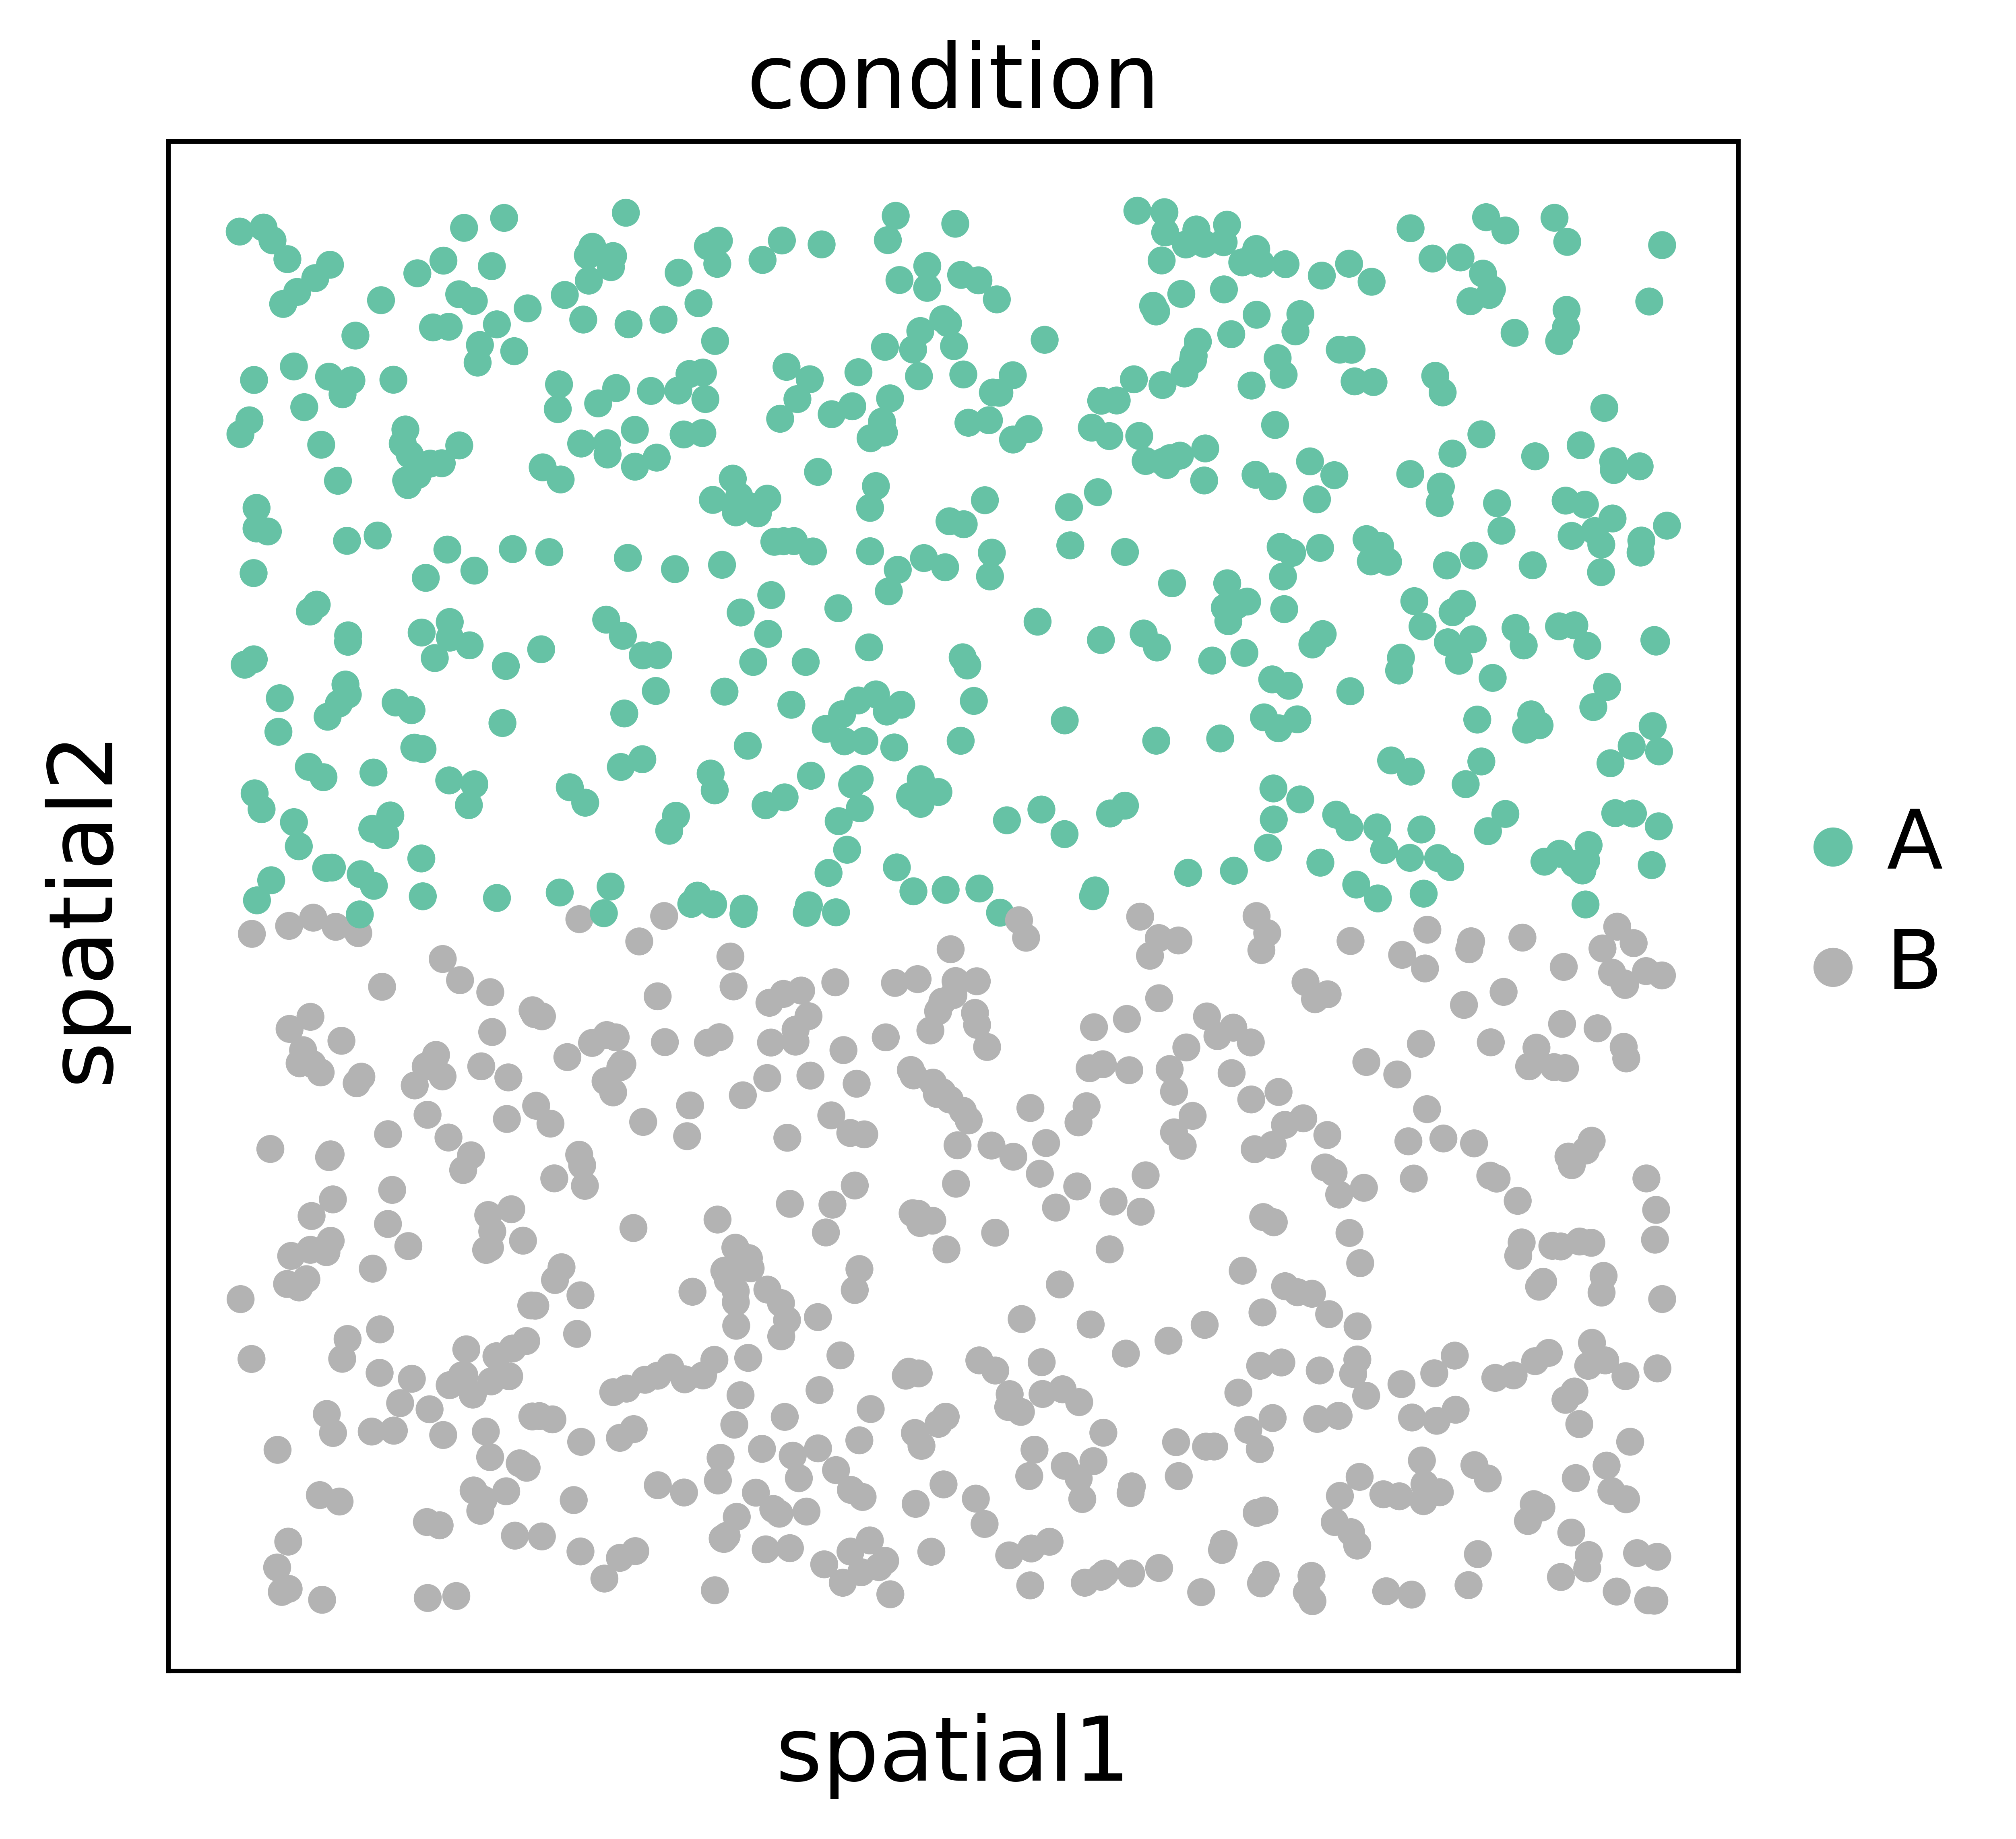

In [6]:
# spatial plot labeled by condition/group
sc.set_figure_params(vector_friendly=True, dpi=500, figsize=(5,5), fontsize=16)
sc.pl.embedding(adata, "spatial", color="condition", size=100, show=False, palette="Set2")
plt.savefig(f"plots/scpi_clustering/REVISED_simulated_label_spatial.pdf", bbox_inches="tight", dpi=300)
plt.show()

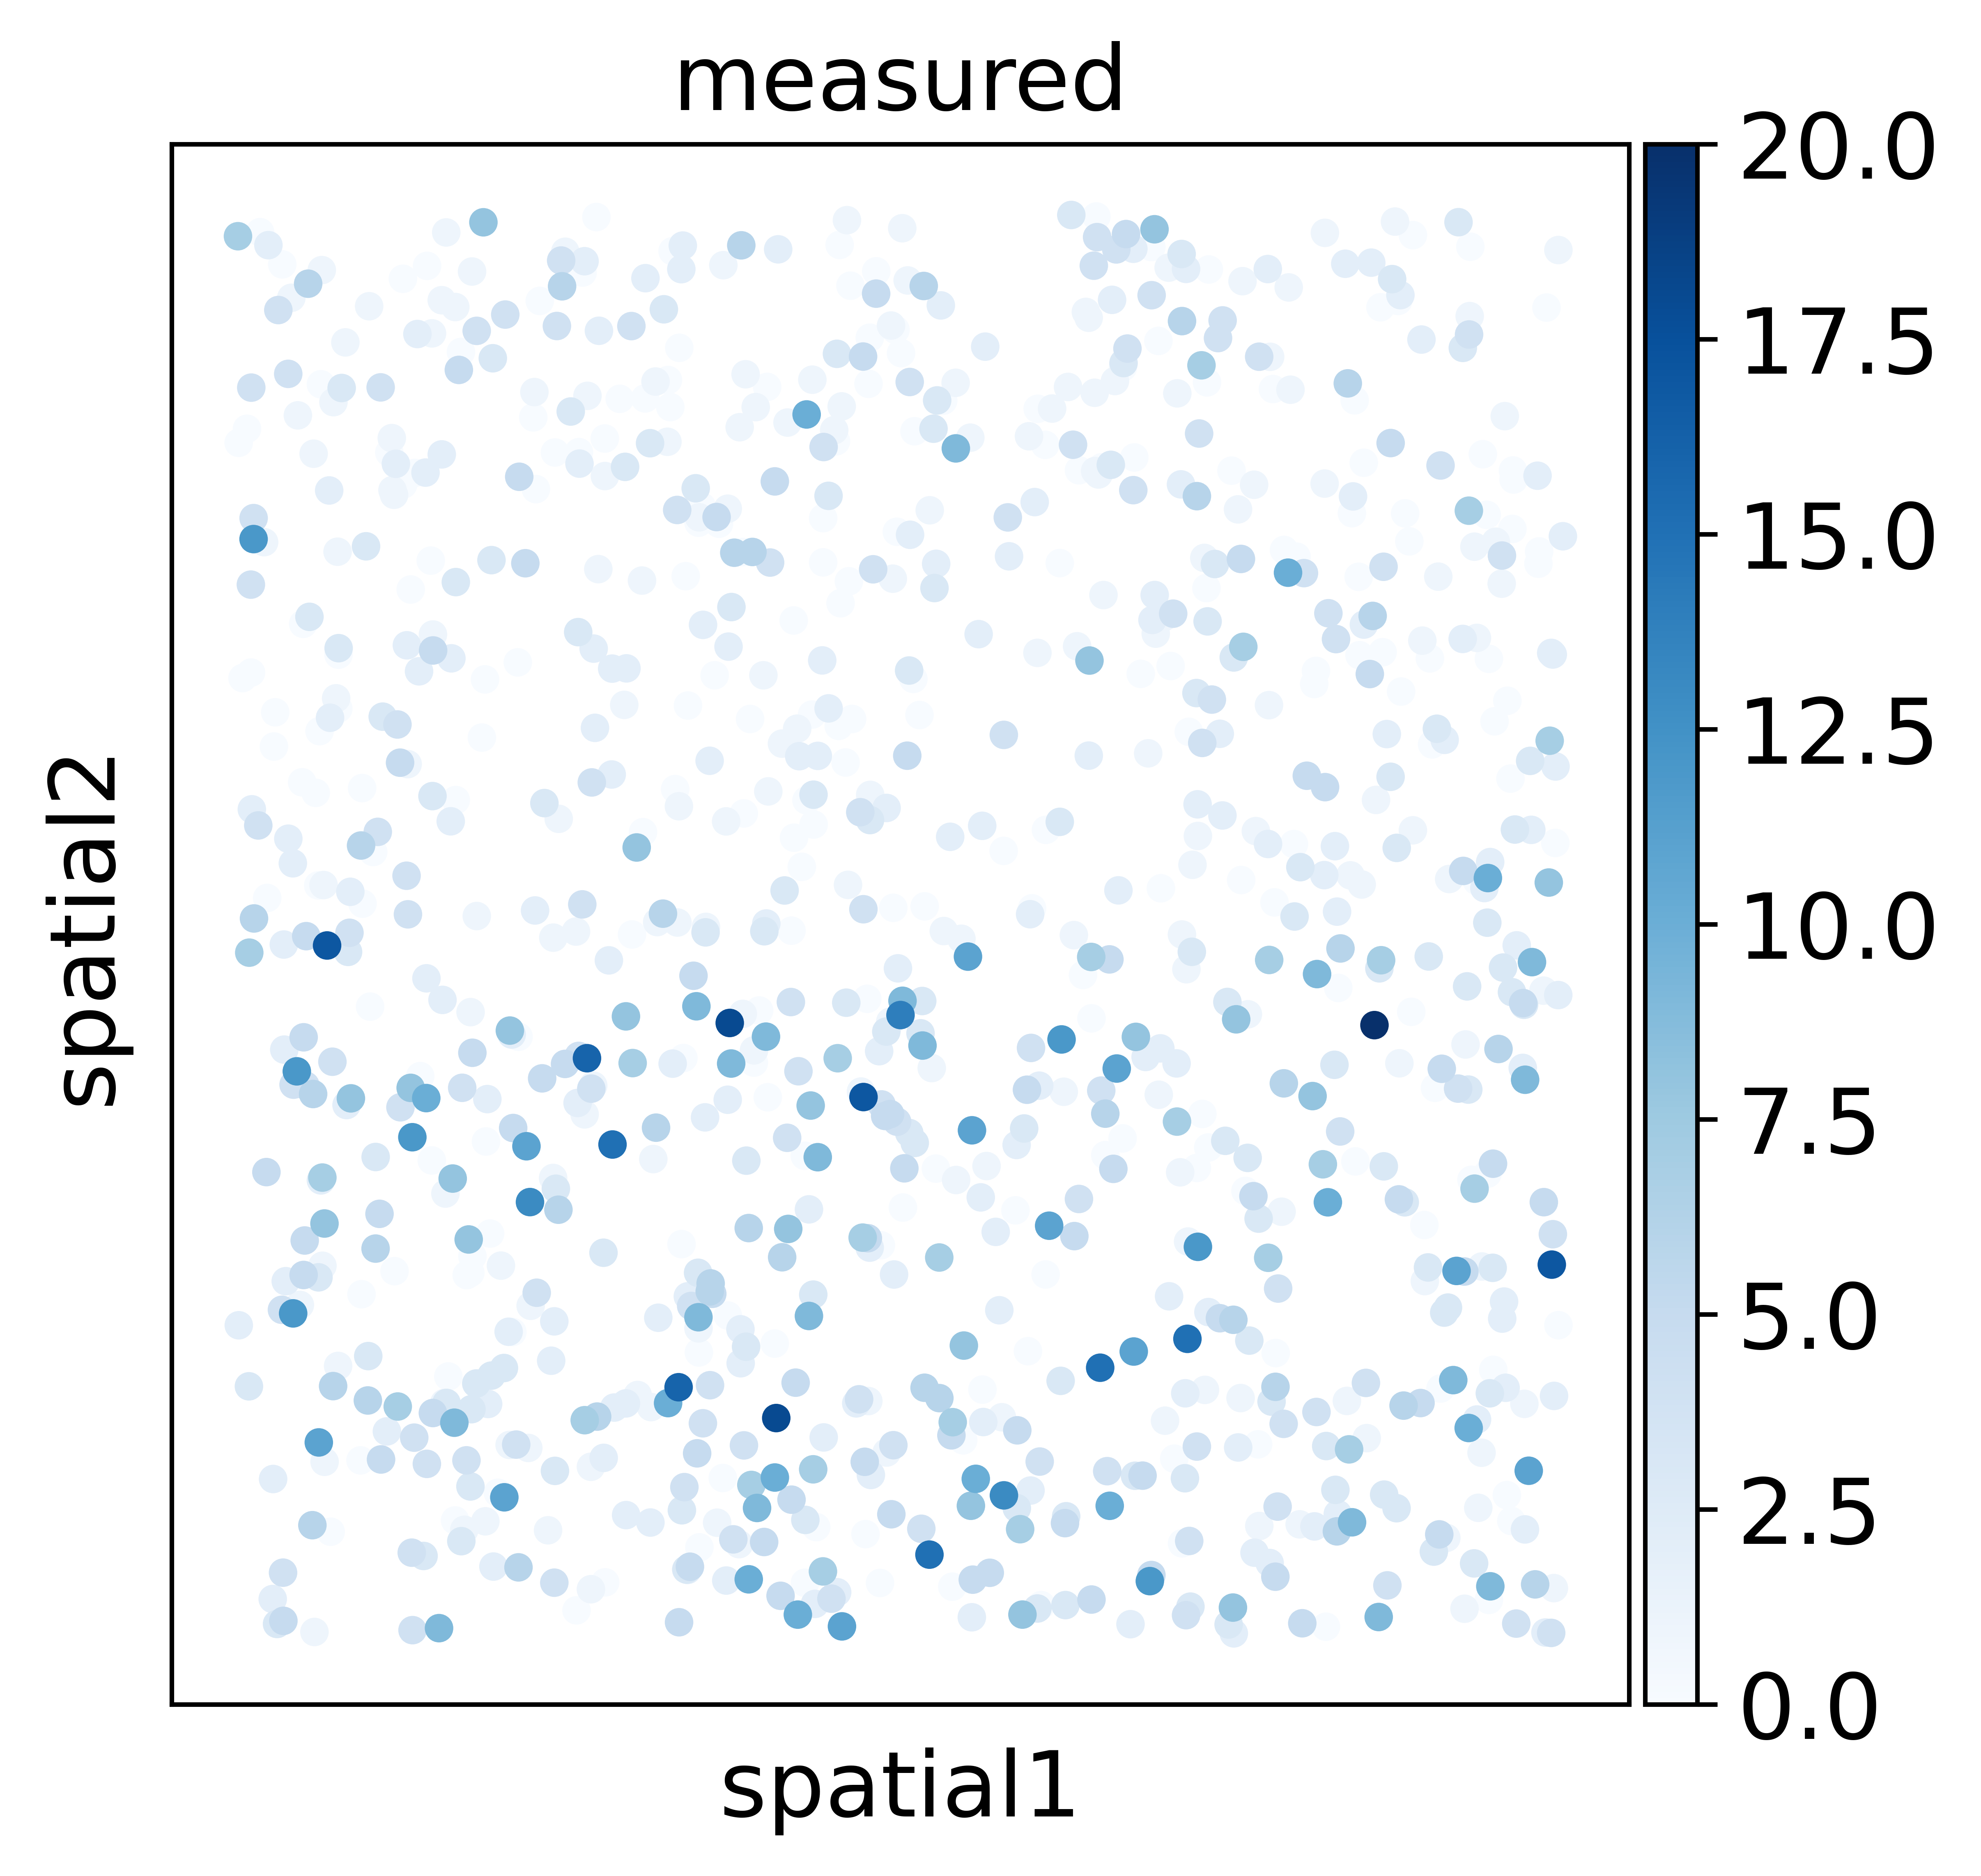

In [7]:
# spatial plot labeled by measured expression of first gene

gene = "signal1"

adata.obs["measured"] = adata[:,gene].X.flatten().copy()

sc.set_figure_params(vector_friendly=True, dpi=500, figsize=(5,5), fontsize=16)
sc.pl.embedding(adata, "spatial", color="measured", size=100, show=False, color_map='Blues', vmin=0, vmax=20)
plt.savefig(f"plots/scpi_clustering/REVISED_simulated_measured_spatial.pdf", bbox_inches="tight", dpi=300)
plt.show()

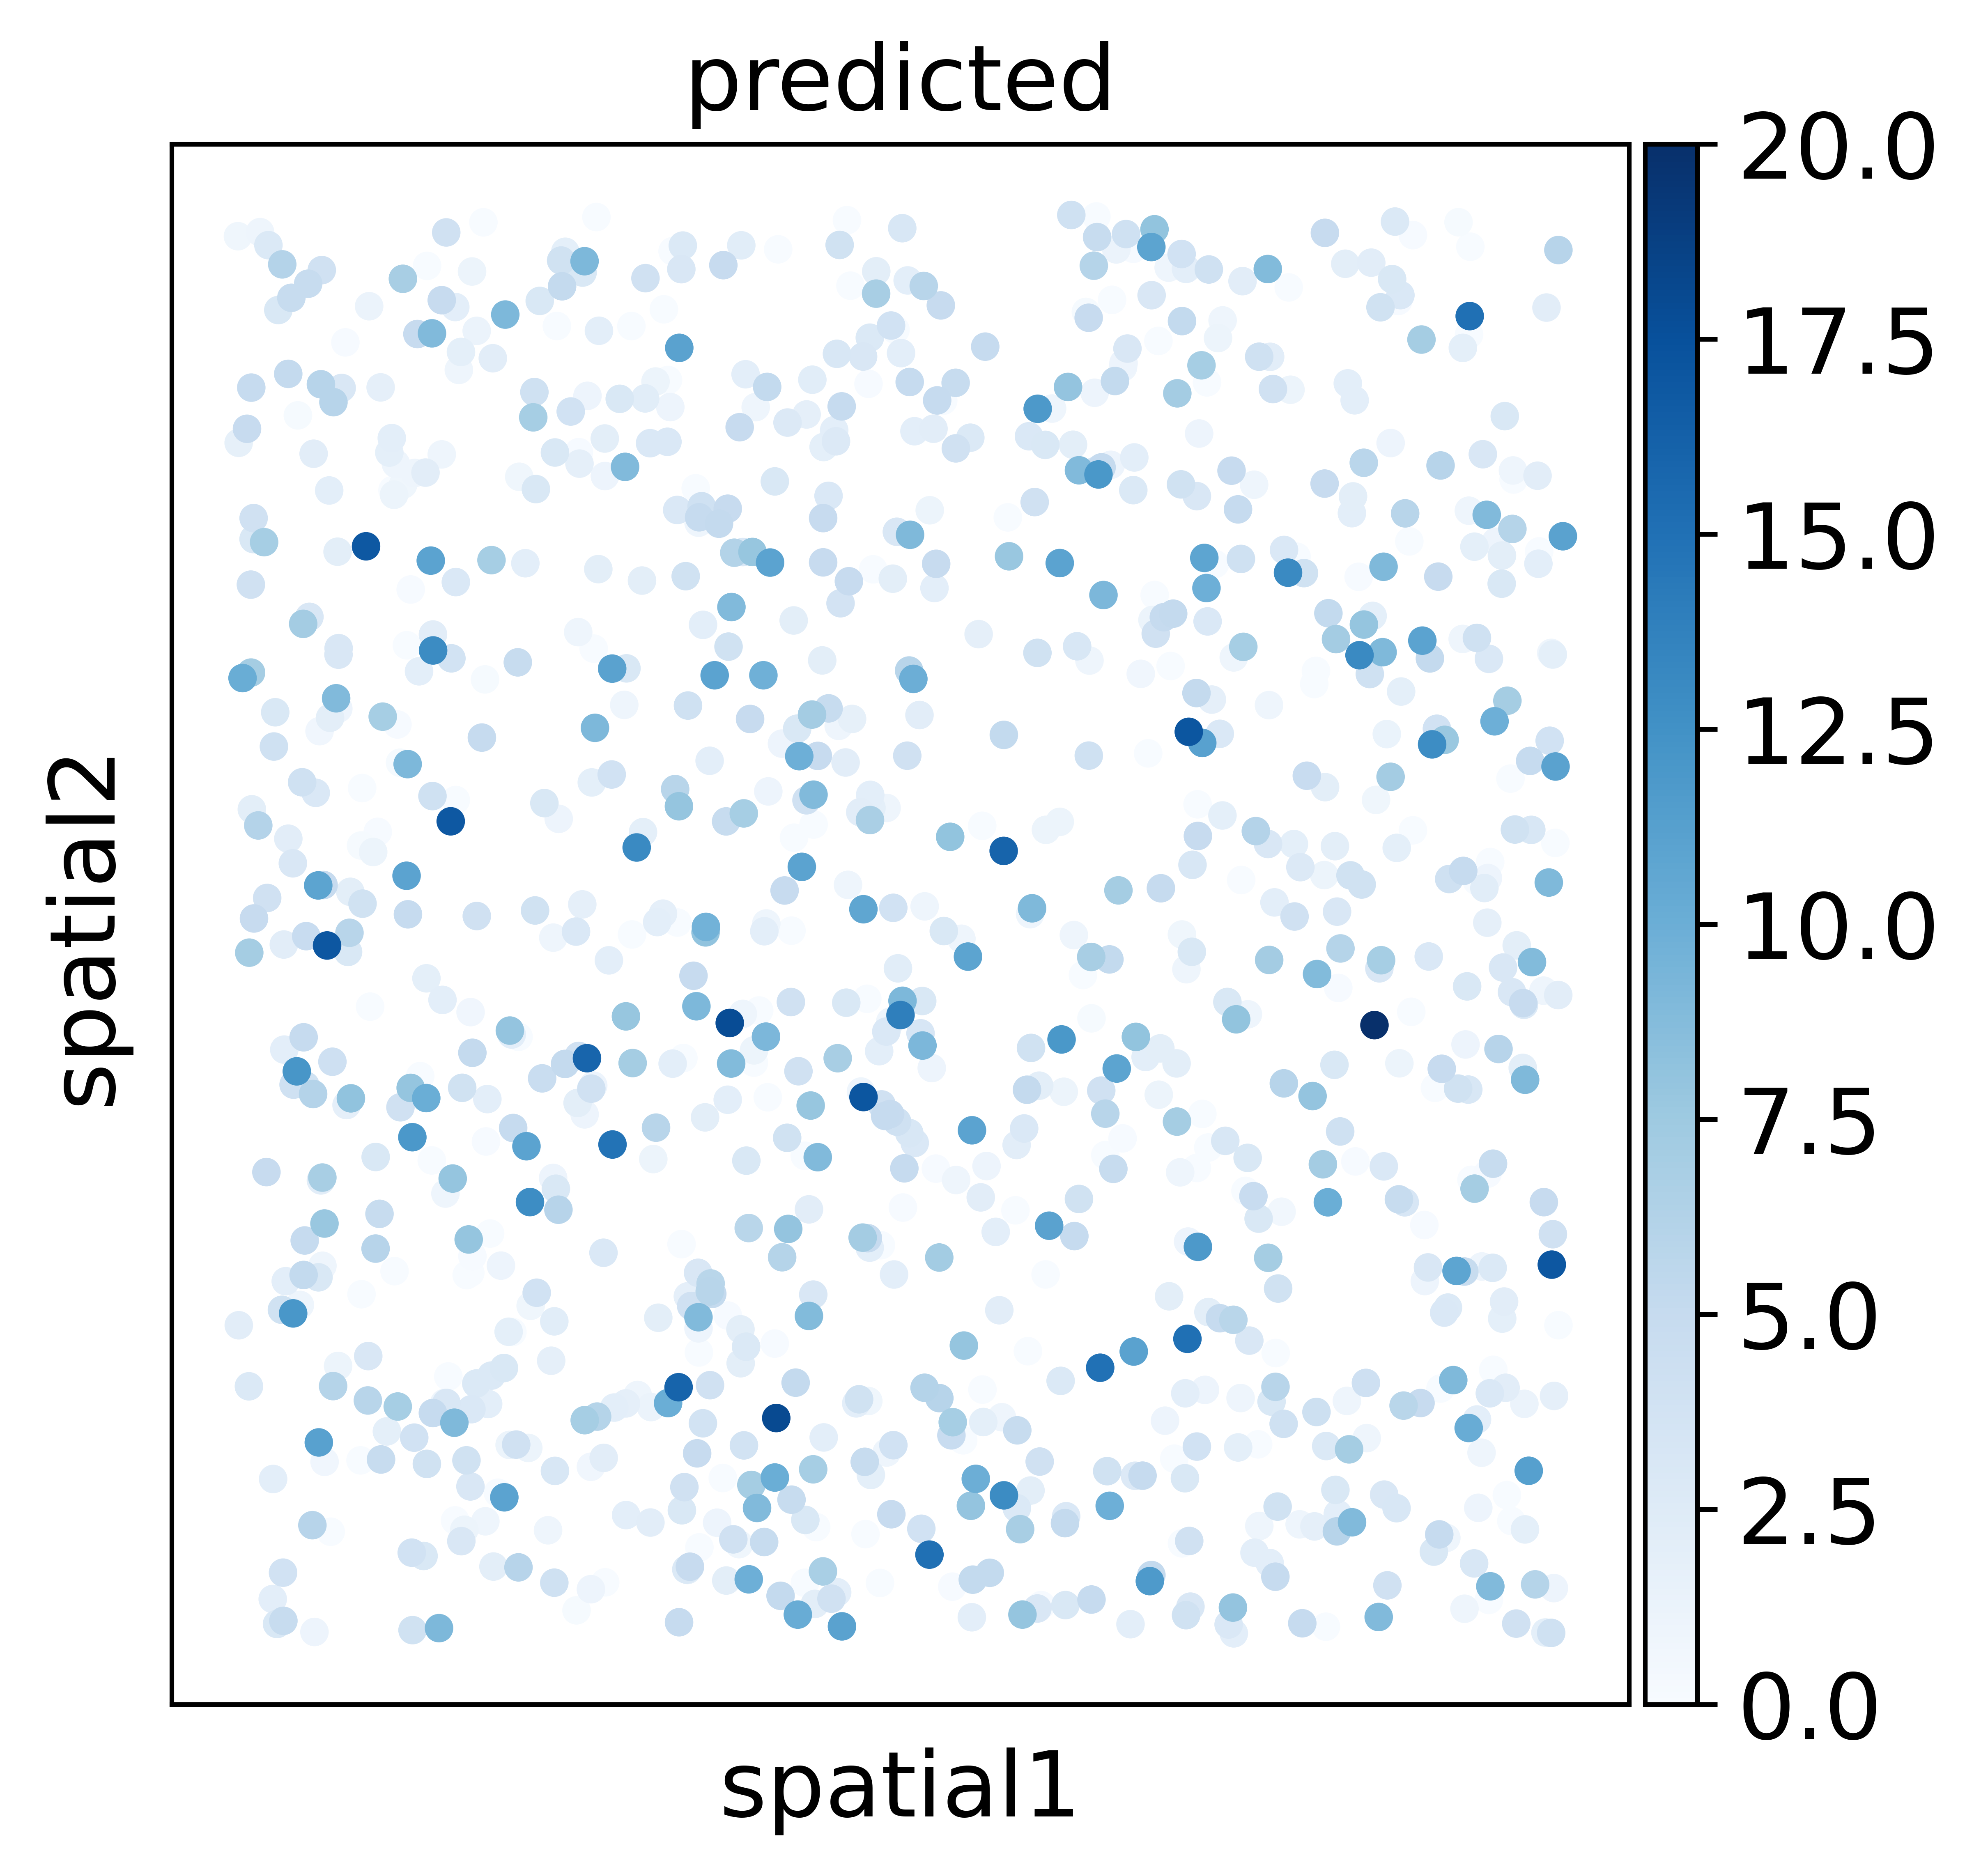

In [8]:
# spatial plot labeled by predicted expression (with bias) of first gene

gene = "signal1"

adata.obs["predicted"] = adata.obsm["sim_predicted_expression"][gene].copy()

sc.set_figure_params(vector_friendly=True, dpi=500, figsize=(5,5), fontsize=16)
sc.pl.embedding(adata, "spatial", color="predicted", size=100, show=False, color_map="Blues", vmin=0, vmax=20)
plt.savefig(f"plots/scpi_clustering/REVISED_simulated_predicted_spatial.pdf", bbox_inches="tight", dpi=300)
plt.show()

### Generate multiple PC visualizations for DynamicViz

Performs multiple predictions simulations from the base data and then visualizes then along the first two principal components using either the baseline approach (normal PCA) or with TISSUE-filtered input/output for the PCA. This will generate the input for `04_dynamicviz_pca_plots.ipynb`.

In [4]:
mix = 0.5
n_components=15
n_runs = 20
filter_proportion='otsu'

results_dict = {}
for key in ["measured", "imputed", "imputed-filtered"]:
    results_dict[key] = {}
    results_dict[key]['x1'] = []
    results_dict[key]['x2'] = []
    results_dict[key]['original_index'] = []
    results_dict[key]['bootstrap_number'] = []
    results_dict[key]['label'] = []


#####################################
for i in range(n_runs):
    
    adata, calib_genes, labels = simulate_data_fromfile('SRTsim_main_two_conditions_different', mixing=mix, prop_biased=1.0, mixin_setup=["B","A"])
    true_clusters = labels

    # build spatial graph
    build_spatial_graph(adata, method="fixed_radius", n_neighbors=15)

    # conformalize
    conformalize_spatial_uncertainty(adata, "sim_predicted_expression", calib_genes, weight="exp_cos", mean_normalized=False,
                                     grouping_method="kmeans_gene_cell", k='auto', k2='auto', n_pc=15)

    # get PI's
    conformalize_prediction_interval(adata, "sim_predicted_expression", calib_genes, alpha_level=0.33)
    
    
    # run PCA for measured
    X_red = StandardScaler().fit_transform(adata.X)
    X_red = PCA(n_components=n_components).fit_transform(X_red)
    
    # run PCA for predicted
    filtered_PCA(adata, "sim", proportion=0, stratification=labels) # set proportion=0 to recover base PCA
    X_red_imp = adata.obsm[f'sim_predicted_expression_PC{n_components}_'].copy()
    
    # run PCA for filtering by TISSUE on predicted
    unc_keep_idxs = filtered_PCA(adata, "sim", proportion=filter_proportion, stratification=labels,
                                     return_keep_idxs=True)
    X_red_imp_unc_fil = adata.uns[f'sim_predicted_expression_PC{n_components}_filtered_'].copy()
    
    
    # append results
    results_dict["measured"]['x1'].append(X_red[:,0])
    results_dict["measured"]['x2'].append(X_red[:,1])
    results_dict["measured"]['original_index'].append(np.arange(X_red.shape[0]))
    results_dict["measured"]['bootstrap_number'].append(np.ones(X_red.shape[0])*i)
    results_dict["measured"]['label'].append(true_clusters)
    
    results_dict["imputed"]['x1'].append(X_red_imp[:,0])
    results_dict["imputed"]['x2'].append(X_red_imp[:,1])
    results_dict["imputed"]['original_index'].append(np.arange(X_red_imp.shape[0]))
    results_dict["imputed"]['bootstrap_number'].append(np.ones(X_red_imp.shape[0])*i)
    results_dict["imputed"]['label'].append(true_clusters)
    
    results_dict["imputed-filtered"]['x1'].append(X_red_imp_unc_fil[:,0])
    results_dict["imputed-filtered"]['x2'].append(X_red_imp_unc_fil[:,1])
    results_dict["imputed-filtered"]['original_index'].append(np.array(unc_keep_idxs))
    results_dict["imputed-filtered"]['bootstrap_number'].append(np.ones(X_red_imp_unc_fil.shape[0])*i)
    results_dict["imputed-filtered"]['label'].append(true_clusters[unc_keep_idxs])
    
for key in ["measured", "imputed", "imputed-filtered"]:
    results_dict[key]['x1'] = np.concatenate(results_dict[key]['x1'])
    results_dict[key]['x2'] = np.concatenate(results_dict[key]['x2'])
    results_dict[key]['original_index'] = np.concatenate(results_dict[key]['original_index'])
    results_dict[key]['bootstrap_number'] = np.concatenate( results_dict[key]['bootstrap_number'])
    results_dict[key]['label'] = np.concatenate(results_dict[key]['label'])

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/tmp/ipykernel_2498/307478243.py:55: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.obsm["sim_predicted_expression"] = pd.DataFrame(imputed, columns=adata.var_names, index=adata.obs_names)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.p

/tmp/ipykernel_2498/307478243.py:55: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.obsm["sim_predicted_expression"] = pd.DataFrame(imputed, columns=adata.var_names, index=adata.obs_names)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/tmp/ipykernel_2498/307478243.py:55: FutureWarning: X.dtype being converted to np.float32 fro

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/tmp/ipykernel_2498/307478243.py:55: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.obsm["sim_predicted_expression"] = pd.DataFrame(imputed, columns=adata.var_names, index=adata.obs_names)


In [8]:
# # pickle dict
# with open(f"results/clustering/REVISED_dynamicviz_simulated_50mix.pkl", "wb") as f:
#     pickle.dump(results_dict, f)

## Downstream performance for TISSUE filtering across different mix-in bias levels

For different levels of mix-in bias, generates simulated data and benchmarks TISSUE filtering against baseline approaches for supervised learning (classification accuracy) and clustering/visualization (adjusted rand index).

In [ ]:
filter_proportion = "otsu"
mix_props = np.linspace(0,1,20)
num_replicates = 20

# init dictionary for storing results
mix_dict = {}
for key in ["measured", "imputed", "imputed_unc", "imputed_unc_fil"]:
    mix_dict[key] = {}
    mix_dict[key]["median_acc"] = []
    mix_dict[key]["range_acc"] = []
    mix_dict[key]["median_ari"] = []
    mix_dict[key]["range_ari"] = []


# Run simulation for different mixing proportion settings
for mix in mix_props:
    
    print(mix)
    
    # Prediction Accuracy
    measured_accs = []
    imputed_accs = []
    imputed_unc_accs = []
    
    # Clustering/Visualization (Adjusted rand index)
    measured_ari = []
    imputed_ari = []
    imputed_unc_ari = []
    imputed_unc_fil_ari = []

    
    for i in range(num_replicates):
                
        ####################################################################
        # Get TISSUE prediction intervals
        ####################################################################
        
        
        adata, calib_genes, labels = simulate_data_fromfile('SRTsim_main_two_conditions_different', mixing=mix, prop_biased=1.0, mixin_setup=["B","A"])
        true_clusters = labels

        # build spatial graph
        build_spatial_graph(adata, method="fixed_radius", n_neighbors=15)

        # conformalize
        conformalize_spatial_uncertainty(adata, "sim_predicted_expression", calib_genes, weight="exp_cos", mean_normalized=False,
                                         grouping_method="kmeans_gene_cell", k='auto', k2='auto', n_pc=15)

        # get PI's
        conformalize_prediction_interval(adata, "sim_predicted_expression", calib_genes, alpha_level=0.33)
        
        predicted = "sim_predicted_expression"
        
        ####################################################################
        # Measure prediction accuracy of binary logistic regression model
        ####################################################################
        
        # Imputed - Uncertainty
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
        X = adata.obsm[predicted].values
        splits = kf.split(X, labels)
        unc_acc = []
        for j, (train_index, test_index) in enumerate(splits):
            # get train test
            X_train = X[train_index,:].copy()
            X_train_pi_width = adata.obsm[f'{predicted}_hi'].values[train_index,:] - adata.obsm[f'{predicted}_lo'].values[train_index,:]
            y_train = labels[train_index]
            X_test = X[test_index,:].copy()
            X_test_pi_width = adata.obsm[f'{predicted}_hi'].values[test_index,:] - adata.obsm[f'{predicted}_lo'].values[test_index,:]
            y_test = labels[test_index]
            # filter both independently
            keep_idxs_train = detect_uncertain_cells (X_train_pi_width, proportion=filter_proportion, stratification=y_train)
            keep_idxs_test = detect_uncertain_cells (X_test_pi_width, proportion=filter_proportion, stratification=y_test)
            # fit model
            model = LogisticRegression(penalty='l1', solver='liblinear')
            scaler = StandardScaler()
            X_train[keep_idxs_train,:] = scaler.fit_transform(X_train[keep_idxs_train,:])
            model.fit(X_train[keep_idxs_train,:], y_train[keep_idxs_train])
            # evaluate
            pred_y_test = model.predict(scaler.transform(X_test[keep_idxs_test,:]))
            unc_acc.append(accuracy_score(pred_y_test, y_test[keep_idxs_test]))
        unc_acc = np.mean(unc_acc)
        imputed_unc_accs.append(unc_acc)

        # Imputed
        model = LogisticRegression(penalty='l1', solver='liblinear')
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
        X = adata.obsm[predicted].values
        X = StandardScaler().fit_transform(X)
        imp_acc = cross_val_score(model, X, labels, cv=kf).mean()
        imputed_accs.append(imp_acc)

        # Measured
        model = LogisticRegression(penalty='l1', solver='liblinear')
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
        X = adata.X
        X = StandardScaler().fit_transform(X)
        measured_acc = cross_val_score(model, X, labels, cv=kf).mean()
        measured_accs.append(measured_acc)
        
        
        ###########################
        # Perform clustering (ARI)
        ###########################
        
        # Set up initial inputs
        
        # Imputed - Uncertainty
        unc_keep_idxs = filtered_PCA(adata, "sim", proportion=filter_proportion, stratification=labels,
                                     return_keep_idxs=True)
        X_red_imp_unc = adata.obsm['sim_predicted_expression_PC15_'].copy()
        X_red_imp_unc_fil = adata.uns['sim_predicted_expression_PC15_filtered_'].copy()
        
        # Imputed
        filtered_PCA(adata, "sim", proportion=0, stratification=labels)
        X_red_imp = adata.obsm['sim_predicted_expression_PC15_'].copy()
        
        # Measured
        X = adata.X
        X = StandardScaler().fit_transform(X)
        X_red_measured = PCA(n_components=15).fit_transform(X)
        
    
        #### Clustering + Compute ARI
        kmeans = KMeans(n_clusters=2).fit(X_red_imp_unc)
        clusters = kmeans.labels_
        imputed_unc_ari.append(adjusted_rand_score(true_clusters, clusters))
        
        kmeans = KMeans(n_clusters=2).fit(X_red_imp_unc_fil)
        clusters = kmeans.labels_
        imputed_unc_fil_ari.append(adjusted_rand_score(true_clusters[unc_keep_idxs], clusters))
        
        kmeans = KMeans(n_clusters=2).fit(X_red_imp)
        clusters = kmeans.labels_
        imputed_ari.append(adjusted_rand_score(true_clusters, clusters))
        
        kmeans = KMeans(n_clusters=2).fit(X_red_measured)
        clusters = kmeans.labels_
        measured_ari.append(adjusted_rand_score(true_clusters, clusters))
        
    # append results
    mix_dict["measured"]["median_acc"].append(np.nanmedian(measured_accs))
    mix_dict["imputed"]["median_acc"].append(np.nanmedian(imputed_accs))
    mix_dict["imputed_unc"]["median_acc"].append(np.nanmedian(imputed_unc_accs))
    mix_dict["measured"]["range_acc"].append((np.nanquantile(measured_accs,0.25),(np.nanquantile(measured_accs,0.75))))
    mix_dict["imputed"]["range_acc"].append((np.nanquantile(imputed_accs,0.25),(np.nanquantile(imputed_accs,0.75))))
    mix_dict["imputed_unc"]["range_acc"].append((np.nanquantile(imputed_unc_accs,0.25),(np.nanquantile(imputed_unc_accs,0.75))))
    
    mix_dict["measured"]["median_ari"].append(np.nanmedian(measured_ari))
    mix_dict["imputed"]["median_ari"].append(np.nanmedian(imputed_ari))
    mix_dict["imputed_unc"]["median_ari"].append(np.nanmedian(imputed_unc_ari))
    mix_dict["imputed_unc_fil"]["median_ari"].append(np.nanmedian(imputed_unc_fil_ari))
    mix_dict["measured"]["range_ari"].append((np.nanquantile(measured_ari,0.25),(np.nanquantile(measured_ari,0.75))))
    mix_dict["imputed"]["range_ari"].append((np.nanquantile(imputed_ari,0.25),(np.nanquantile(imputed_ari,0.75))))
    mix_dict["imputed_unc"]["range_ari"].append((np.nanquantile(imputed_unc_ari,0.25),(np.nanquantile(imputed_unc_ari,0.75))))
    mix_dict["imputed_unc_fil"]["range_ari"].append((np.nanquantile(imputed_unc_fil_ari,0.25),(np.nanquantile(imputed_unc_fil_ari,0.75))))

In [11]:
# pickle dict
# with open(f"results/prediction/simulated_mix_0_1_20_default_params_20rep_FINAL_filterotsu_mainSRTsim_ALL_METRICS_bias100_ABrev.pkl", "wb") as f:
#     pickle.dump(mix_dict, f)

## Generating summary figures for key metrics

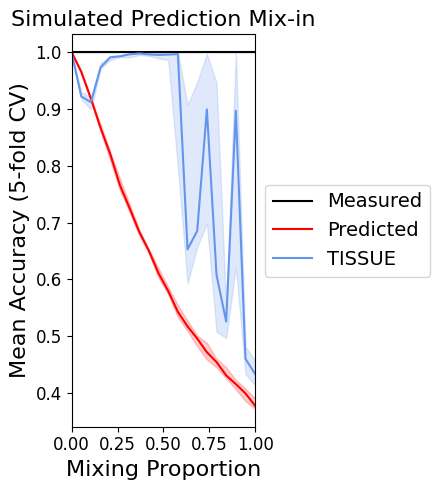

In [3]:
# Make plots for Accuracy

filename = "simulated_mix_0_1_20_default_params_20rep_FINAL_filterotsu_mainSRTsim_ALL_METRICS_bias100_ABrev"
mix_props = np.linspace(0,1,20)
start = 0

########################################
with open(f"results/prediction/{filename}.pkl", "rb") as f:
    mix_dict = pickle.load(f)

plt.figure(figsize=(4.5,5))

# plot median curve
plt.plot(mix_props[start:], mix_dict["measured"]["median_acc"][start:], label="Measured", color="k")
plt.plot(mix_props[start:], mix_dict["imputed"]["median_acc"][start:], label="Predicted", color="r")
plt.plot(mix_props[start:], mix_dict["imputed_unc"]["median_acc"][start:], label="TISSUE", color="cornflowerblue")

# fill in shaded range
plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["measured"]["range_acc"]][start:],
                 [x[1] for x in mix_dict["measured"]["range_acc"]][start:], color="k", alpha=0.2)
plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["imputed"]["range_acc"]][start:],
                 [x[1] for x in mix_dict["imputed"]["range_acc"]][start:], color="r", alpha=0.2)
plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["imputed_unc"]["range_acc"]][start:],
                 [x[1] for x in mix_dict["imputed_unc"]["range_acc"]][start:], color="cornflowerblue", alpha=0.2)

# annotate plot
plt.title("Simulated Prediction Mix-in", fontsize=16)
plt.xlabel(r"Mixing Proportion", fontsize=16)
plt.ylabel("Mean Accuracy (5-fold CV)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xlim(np.min(mix_props[start:]),np.max(mix_props[start:]))
plt.tight_layout()
plt.savefig(f"plots/scpi_prediction/REVISED_{filename}_ACC.pdf", bbox_inches="tight")
plt.show()

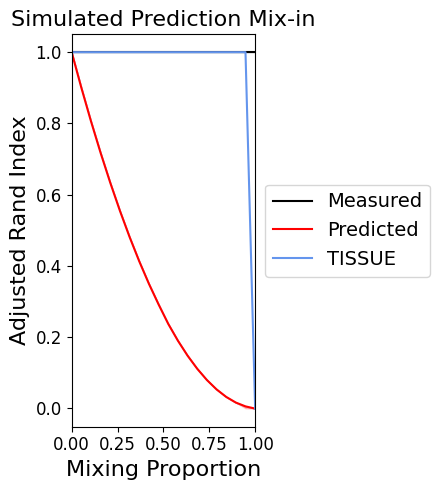

In [4]:
# Make plots for ARI

filename = "simulated_mix_0_1_20_default_params_20rep_FINAL_filterotsu_mainSRTsim_ALL_METRICS_bias90_ABrev"
mix_props = np.linspace(0,1,20)
start = 0

########################################
with open(f"results/prediction/{filename}.pkl", "rb") as f:
    mix_dict = pickle.load(f)

plt.figure(figsize=(4.5,5))

# plot median curve
plt.plot(mix_props[start:], mix_dict["measured"]["median_ari"][start:], label="Measured", color="k")
plt.plot(mix_props[start:], mix_dict["imputed"]["median_ari"][start:], label="Predicted", color="r")
plt.plot(mix_props[start:], mix_dict["imputed_unc_fil"]["median_ari"][start:], label="TISSUE", color="cornflowerblue")

# fill in shaded range
plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["measured"]["range_ari"]][start:],
                 [x[1] for x in mix_dict["measured"]["range_ari"]][start:], color="k", alpha=0.2)
plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["imputed"]["range_ari"]][start:],
                 [x[1] for x in mix_dict["imputed"]["range_ari"]][start:], color="r", alpha=0.2)
plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["imputed_unc"]["range_ari"]][start:],
                 [x[1] for x in mix_dict["imputed_unc"]["range_ari"]][start:], color="cornflowerblue", alpha=0.2)

# annotate plot
plt.title("Simulated Prediction Mix-in", fontsize=16)
plt.xlabel(r"Mixing Proportion", fontsize=16)
plt.ylabel("Adjusted Rand Index", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xlim(np.min(mix_props[start:]),np.max(mix_props[start:]))
plt.tight_layout()
plt.savefig(f"plots/scpi_prediction/REVISED_{filename}_ARI.pdf", bbox_inches="tight")
plt.show()

### Control test: Improvement persists with filtering only applied to the fitting of the PCA model

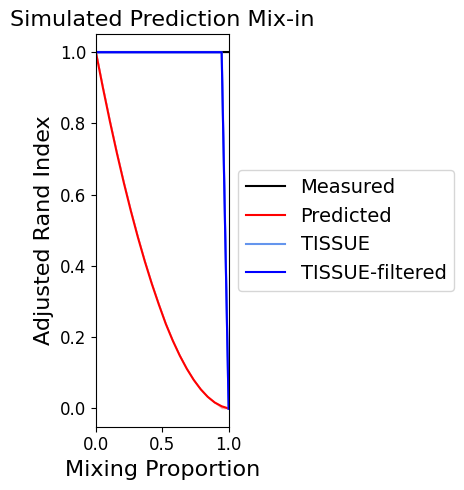

In [5]:
# Make plots for ARI

filename = "simulated_mix_0_1_20_default_params_20rep_FINAL_filterotsu_mainSRTsim_ALL_METRICS_bias90_ABrev"
mix_props = np.linspace(0,1,20)
start = 0

########################################
with open(f"results/prediction/{filename}.pkl", "rb") as f:
    mix_dict = pickle.load(f)

plt.figure(figsize=(4.5,5))

# plot median curve
plt.plot(mix_props[start:], mix_dict["measured"]["median_ari"][start:], label="Measured", color="k")
plt.plot(mix_props[start:], mix_dict["imputed"]["median_ari"][start:], label="Predicted", color="r")
plt.plot(mix_props[start:], mix_dict["imputed_unc_fil"]["median_ari"][start:], label="TISSUE", color="cornflowerblue")
plt.plot(mix_props[start:], mix_dict["imputed_unc_fil"]["median_ari"][start:], label="TISSUE-filtered", color="b")

# fill in shaded range
plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["measured"]["range_ari"]][start:],
                 [x[1] for x in mix_dict["measured"]["range_ari"]][start:], color="k", alpha=0.2)
plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["imputed"]["range_ari"]][start:],
                 [x[1] for x in mix_dict["imputed"]["range_ari"]][start:], color="r", alpha=0.2)
plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["imputed_unc"]["range_ari"]][start:],
                 [x[1] for x in mix_dict["imputed_unc"]["range_ari"]][start:], color="cornflowerblue", alpha=0.2)
plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["imputed_unc_fil"]["range_ari"]][start:],
                 [x[1] for x in mix_dict["imputed_unc_fil"]["range_ari"]][start:], color="b", alpha=0.2)

# annotate plot
plt.title("Simulated Prediction Mix-in", fontsize=16)
plt.xlabel(r"Mixing Proportion", fontsize=16)
plt.ylabel("Adjusted Rand Index", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xlim(np.min(mix_props[start:]),np.max(mix_props[start:]))
plt.tight_layout()
plt.savefig(f"plots/scpi_prediction/REVISED_{filename}_ARI_all.pdf", bbox_inches="tight")
plt.show()